In [1]:
import os
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import pathlib

In [2]:
# CKPT_PATH = "exported-models/my_model/checkpoint/ckpt-0"
# CKPT_PATH = "models/my_ssd_mobile_netv2_v1_fpn/ckpt-17"
# Saved 
# PIPELINE_CONFIG_PATH = "models/my_ssd_mobile_netv2_v1_fpn/pipeline.config"
# PIPELINE_CONFIG_PATH = "exported-models/my_model/pipeline.config"


LABEL_MAP_PATH = "annotations/label_map.pbtxt"

# # ssd mobilenetpre trained
PATH_TO_SAVED_MODEL = "exported-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
PIPELINE_CONFIG_PATH = "models/my_ssd_mobile_netv2_v1_fpn/pipeline.config"
CKPT_PATH = "models/my_ssd_mobile_netv2_v1_fpn/ckpt-50"


# # ssd resnet netpre trained
# PATH_TO_SAVED_MODEL = "exported-models/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8"
# PIPELINE_CONFIG_PATH = "pretrained-models/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8/pipeline.config"
# CKPT_PATH = "pretrained-models/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0"

# # ssd resnet netpre trained
# PATH_TO_SAVED_MODEL = "exported-models/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8"
# PIPELINE_CONFIG_PATH = "pretrained-models/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8/pipeline.config"
# CKPT_PATH = "pretrained-models/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0"




# # ssd resnet trained
# PATH_TO_SAVED_MODEL = "models/ssd_resnet152"
# PIPELINE_CONFIG_PATH = "models/ssd_resnet152/pipeline.config"
# # CKPT_PATH = "models/ssd_resnet152/checkpoint/ckpt-3"
# CKPT_PATH = "models/ssd_resnet152/ckpt-3"
# # PATH_TO_SAVED_MODEL = "exported-models/my_model"


# # ssd resnet trained
# PATH_TO_SAVED_MODEL = "models/ssd_resnet152_2"
# PIPELINE_CONFIG_PATH = "models/ssd_resnet152_2/pipeline.config"
# # CKPT_PATH = "models/ssd_resnet152/checkpoint/ckpt-"
# CKPT_PATH = "models/ssd_resnet152_2/ckpt-25"
# # PATH_TO_SAVED_MODEL = "exported-models/my_model"

PILOT_IMG_PATH ="images_pilot/1_rangerover_tracking.jpg"

In [3]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)
def download_images():
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'
    filenames = ['image1.jpg', 'image2.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths

IMAGE_PATHS = download_images()
LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

In [4]:
IMAGE_PATHS

['C:\\Users\\user\\.keras\\datasets\\image1.jpg',
 'C:\\Users\\user\\.keras\\datasets\\image2.jpg']

In [5]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH)
# category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS)


fol = "test"
li = [ f for f in os.listdir(os.path.join("images", fol)) if f[-3:] =="jpg"]

In [7]:
category_index

{1: {'id': 1, 'name': 'mb_marker_buoy_black'},
 2: {'id': 2, 'name': 'mb_marker_buoy_green'},
 3: {'id': 3, 'name': 'mb_marker_buoy_red'},
 4: {'id': 4, 'name': 'mb_marker_buoy_white'},
 5: {'id': 5, 'name': 'mb_round_buoy_black'},
 6: {'id': 6, 'name': 'mb_round_buoy_orange'}}

In [8]:
IMAGE_PATH = os.path.join("images", fol, li[116])

In [9]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
# ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-5')).expect_partial()
ckpt.restore(CKPT_PATH).expect_partial()

# ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'])).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections



In [10]:
CKPT_PATH

'models/my_ssd_mobile_netv2_v1_fpn/ckpt-50'

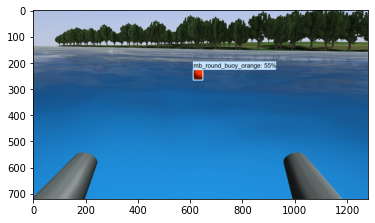

In [24]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB ), 0), dtype=tf.float32)
# input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates= True,
            max_boxes_to_draw=40,
            min_score_thresh=0.2,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
tmp = np.copy(detections["detection_boxes"][0])
tmp = tmp.astype(np.int8)
print(tmp)

[0 0 0 0]


In [28]:
image_np_with_detections.shape

(720, 1280, 3)

In [27]:
class DetectorTF2:

	def __init__(self, path_to_checkpoint, path_to_labelmap, class_id=None, threshold=0.5):
		# class_id is list of ids for desired classes, or None for all classes in the labelmap
		self.class_id = class_id
		self.Threshold = threshold
		# Loading label map
		label_map = label_map_util.load_labelmap(path_to_labelmap)
		categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
		self.category_index = label_map_util.create_category_index(categories)

		tf.keras.backend.clear_session()
		self.detect_fn = tf.saved_model.load(path_to_checkpoint)


	def DetectFromImage(self, img):
		im_height, im_width, _ = img.shape
		# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
		input_tensor = np.expand_dims(img, 0)
		detections = self.detect_fn(input_tensor)

		bboxes = detections['detection_boxes'][0].numpy()
		bclasses = detections['detection_classes'][0].numpy().astype(np.int32)
		bscores = detections['detection_scores'][0].numpy()
		det_boxes = self.ExtractBBoxes(bboxes, bclasses, bscores, im_width, im_height)

		return det_boxes


	def ExtractBBoxes(self, bboxes, bclasses, bscores, im_width, im_height):
		bbox = []
		for idx in range(len(bboxes)):
			if self.class_id is None or bclasses[idx] in self.class_id:
				if bscores[idx] >= self.Threshold:
					y_min = int(bboxes[idx][0] * im_height)
					x_min = int(bboxes[idx][1] * im_width)
					y_max = int(bboxes[idx][2] * im_height)
					x_max = int(bboxes[idx][3] * im_width)
					class_label = self.category_index[int(bclasses[idx])]['name']
					bbox.append([x_min, y_min, x_max, y_max, class_label, float(bscores[idx])])
		return bbox


	def DisplayDetections(self, image, boxes_list, det_time=None):
		if not boxes_list: return image  # input list is empty
		img = image.copy()
		for idx in range(len(boxes_list)):
			x_min = boxes_list[idx][0]
			y_min = boxes_list[idx][1]
			x_max = boxes_list[idx][2]
			y_max = boxes_list[idx][3]
			cls =  str(boxes_list[idx][4])
			score = str(np.round(boxes_list[idx][-1], 2))

			text = cls + ": " + score
			cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
			cv2.rectangle(img, (x_min, y_min - 20), (x_min, y_min), (255, 255, 255), -1)
			cv2.putText(img, text, (x_min + 5, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

		if det_time != None:
			fps = round(1000. / det_time, 1)
			fps_txt = str(fps) + " FPS"
			cv2.putText(img, fps_txt, (25, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

		return img

array([0.3161085, 0.4779511, 0.3695427, 0.507727 ], dtype=float32)

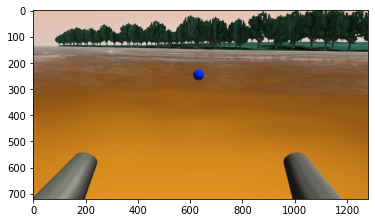

In [21]:
im = np.copy(img)

plt.imshow(cv2.rectangle(im, (tmp[0], tmp[1]), (tmp[2], tmp[3]), (0, 255, 0), 5))

In [26]:
plt.imsave("output.jpg",cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB) )


In [2]:
import tensorflow as tf

In [14]:
# Loading saved mode.
model = tf.saved_model.load("D:\\Development\\Robotics\\vision\\tf_object_Detection_2d_iteration\\Tensorflow\\workspace\\vrx_train\exported-models\\my_model\\saved_model")

# Pre-processing image.
image = tf.image.decode_image(open(IMAGE_PATH, 'rb').read(), channels=3)
image = tf.expand_dims(image, 0)
image = tf.image.resize(image, (320, 320))

# Model expects tf.uint8 tensor, but image is read as tf.float32.
image = tf.image.convert_image_dtype(image, tf.uint8)

# Executing object detection.
detections = model(image)

# Formatting returned detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}

detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

In [17]:
detections.keys()

dict_keys(['detection_boxes', 'detection_anchor_indices', 'detection_scores', 'detection_classes', 'raw_detection_scores', 'detection_multiclass_scores', 'raw_detection_boxes', 'num_detections'])

In [18]:
detections["detection_scores"]

array([0.40154836, 0.1217269 , 0.11971921, 0.10287735, 0.0979847 ,
       0.0929209 , 0.09169051, 0.0833984 , 0.07939148, 0.07859853,
       0.07778394, 0.0764356 , 0.07582495, 0.07428783, 0.06741208,
       0.06714278, 0.06588694, 0.06443539, 0.06368002, 0.06364065,
       0.06359339, 0.06096864, 0.06007349, 0.0600208 , 0.05615851,
       0.05221358, 0.05168492, 0.05068284, 0.05005816, 0.04905885,
       0.04865715, 0.04856282, 0.04845032, 0.04665586, 0.04619968,
       0.04528442, 0.0440914 , 0.04316679, 0.04260701, 0.04128489,
       0.04042637, 0.0390875 , 0.03901756, 0.03850675, 0.03835723,
       0.03824699, 0.03797939, 0.03636456, 0.03599966, 0.03593186,
       0.03450143, 0.03224584, 0.02995536, 0.02925441, 0.02920532,
       0.02890185, 0.02776423, 0.02751529, 0.02712485, 0.02571052,
       0.02531496, 0.02485967, 0.02473262, 0.02414635, 0.0240548 ,
       0.02365351, 0.02363342, 0.0236237 , 0.02353749, 0.02296028,
       0.02282307, 0.02250764, 0.02248603, 0.02236795, 0.02229